In [1]:
!pip install numpy pandas matplotlib scikit-learn xgboost lightgbm hyperopt imbalanced-learn

1. Load data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score, precision_recall_curve,
    roc_auc_score, average_precision_score
)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.utils.class_weight import compute_sample_weight

# ================================
# 1. 加载数据
# ================================
df = pd.read_csv("/content/drive/MyDrive/model-citizens/data/Training_TriGuard.csv")
df = df.dropna(subset=['subrogation'])

train, test = train_test_split(df, test_size=0.3, random_state=12, stratify=df['subrogation'])
X_train = train.drop(columns=["subrogation"]).copy()
y_train = train["subrogation"].copy()
X_test = test.drop(columns=["subrogation"]).copy()
y_test = test["subrogation"].copy()

real_test = pd.read_csv("/content/drive/MyDrive/model-citizens/data/Testing_TriGuard.csv")

2. Feature engineering

In [4]:
# ================================
# 2. 特征工程函数
# ================================
def feature_engineer(df):
    """Feature engineering WITHOUT vehicle_made_year/vehicle_age (data quality issues)"""
    df_fe = df.copy()

    # ========================================================================
    # TEMPORAL FEATURES
    # ========================================================================
    df_fe['claim_date'] = pd.to_datetime(df_fe['claim_date'], errors='coerce')
    df_fe['claim_year'] = df_fe['claim_date'].dt.year
    df_fe['claim_month'] = df_fe['claim_date'].dt.month
    df_fe['claim_day'] = df_fe['claim_date'].dt.day
    df_fe['claim_quarter'] = df_fe['claim_date'].dt.quarter
    df_fe['claim_dayofweek'] = df_fe['claim_date'].dt.dayofweek
    df_fe['is_weekend'] = (df_fe['claim_dayofweek'] >= 5).astype(int)
    df_fe['is_monday'] = (df_fe['claim_dayofweek'] == 0).astype(int)
    df_fe['is_friday'] = (df_fe['claim_dayofweek'] == 4).astype(int)
    df_fe['is_q4'] = (df_fe['claim_quarter'] == 4).astype(int)

    season_map = {
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall',
        12: 'Winter', 1: 'Winter', 2: 'Winter'
    }
    df_fe['season'] = df_fe['claim_month'].map(season_map).fillna('Unknown')


    # ========================================================================
    # BINARY CONVERSIONS (for interactions)
    # ========================================================================
    df_fe['witness_binary'] = (df_fe['witness_present_ind'] == 'Y').astype(int)
    df_fe['police_binary'] = df_fe['policy_report_filed_ind']
    df_fe['multicar_binary'] = df_fe['accident_type'].isin(['multi_vehicle_clear', 'multi_vehicle_unclear']).astype(int)
    df_fe['highrisk_site_binary'] = df_fe['accident_site'].isin(['Highway/Intersection', 'Local']).astype(int)

    # ========================================================================
    # CRITICAL INTERACTION FEATURES (2-way)
    # ========================================================================
    df_fe['liab_x_witness'] = df_fe['liab_prct'] * df_fe['witness_binary']
    df_fe['liab_x_police'] = df_fe['liab_prct'] * df_fe['police_binary']
    df_fe['liab_x_multicar'] = df_fe['liab_prct'] * df_fe['multicar_binary']
    df_fe['liab_x_highrisk_site'] = df_fe['liab_prct'] * df_fe['highrisk_site_binary']
    df_fe['liab_x_evidence'] = df_fe['liab_prct'] * (df_fe['witness_binary'] + df_fe['police_binary'])
    df_fe['liab_x_payout'] = df_fe['liab_prct'] * df_fe['claim_est_payout']
    df_fe['liab_x_mileage'] = df_fe['liab_prct'] * df_fe['vehicle_mileage']
    df_fe['witness_x_police'] = df_fe['witness_binary'] * df_fe['police_binary']
    df_fe['witness_x_multicar'] = df_fe['witness_binary'] * df_fe['multicar_binary']
    df_fe['police_x_multicar'] = df_fe['police_binary'] * df_fe['multicar_binary']
    df_fe['multicar_x_highrisk'] = df_fe['multicar_binary'] * df_fe['highrisk_site_binary']
    df_fe['weekend_highway'] = (df_fe['claim_dayofweek'] >= 5).astype(int) * (df_fe['accident_site'] == 'Highway/Intersection').astype(int)
    df_fe['witness_police_multicar'] = df_fe['witness_binary'] * df_fe['police_binary'] * df_fe['multicar_binary']

    # ========================================================================
    # POLYNOMIAL FEATURES (liability & key variables)
    # ========================================================================
    df_fe['liab_prct_squared'] = df_fe['liab_prct'] ** 2
    df_fe['liab_prct_cubed'] = df_fe['liab_prct'] ** 3
    df_fe['liab_prct_sqrt'] = np.sqrt(df_fe['liab_prct'])
    df_fe['liab_prct_log'] = np.log1p(df_fe['liab_prct'])
    df_fe['liab_inverse'] = 100 - df_fe['liab_prct']
    df_fe['liab_inverse_squared'] = (100 - df_fe['liab_prct']) ** 2
    df_fe['log_claim_est_payout'] = np.log1p(df_fe['claim_est_payout'])
    df_fe['log_vehicle_mileage'] = np.log1p(df_fe['vehicle_mileage'])
    df_fe['log_vehicle_price'] = np.log1p(df_fe['vehicle_price'])
    df_fe['log_annual_income'] = np.log1p(df_fe['annual_income'])
    df_fe['sqrt_vehicle_mileage'] = np.sqrt(df_fe['vehicle_mileage'])

    # ========================================================================
    # ACCIDENT TYPE FEATURES
    # ========================================================================
    df_fe['is_multi_vehicle_clear'] = (df_fe['accident_type'] == 'multi_vehicle_clear').astype(int)
    df_fe['is_multi_vehicle_unclear'] = (df_fe['accident_type'] == 'multi_vehicle_unclear').astype(int)
    df_fe['is_single_car'] = (df_fe['accident_type'] == 'single_car').astype(int)
    df_fe['has_recovery_target'] = df_fe['multicar_binary']
    df_fe['recovery_case_clarity'] = 0
    df_fe.loc[df_fe['is_multi_vehicle_clear'] == 1, 'recovery_case_clarity'] = 3
    df_fe.loc[df_fe['is_multi_vehicle_unclear'] == 1, 'recovery_case_clarity'] = 1

    # ========================================================================
    # LIABILITY BUCKETS (fine-grained)
    # ========================================================================
    df_fe['liab_under_10'] = (df_fe['liab_prct'] < 10).astype(int)
    df_fe['liab_10_to_15'] = ((df_fe['liab_prct'] >= 10) & (df_fe['liab_prct'] < 15)).astype(int)
    df_fe['liab_15_to_20'] = ((df_fe['liab_prct'] >= 15) & (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['liab_20_to_25'] = ((df_fe['liab_prct'] >= 20) & (df_fe['liab_prct'] < 25)).astype(int)
    df_fe['liab_25_to_30'] = ((df_fe['liab_prct'] >= 25) & (df_fe['liab_prct'] < 30)).astype(int)
    df_fe['liab_30_to_35'] = ((df_fe['liab_prct'] >= 30) & (df_fe['liab_prct'] < 35)).astype(int)
    df_fe['liab_35_to_40'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 40)).astype(int)
    df_fe['liab_40_to_50'] = ((df_fe['liab_prct'] >= 40) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['liab_over_50'] = (df_fe['liab_prct'] >= 50).astype(int)
    df_fe['not_at_fault'] = df_fe['liab_under_10']
    df_fe['minimal_fault'] = (df_fe['liab_prct'] < 25).astype(int)
    df_fe['low_fault'] = (df_fe['liab_prct'] < 35).astype(int)
    df_fe['shared_fault'] = ((df_fe['liab_prct'] >= 35) & (df_fe['liab_prct'] < 50)).astype(int)
    df_fe['high_fault'] = (df_fe['liab_prct'] >= 50).astype(int)

    # ========================================================================
    # EVIDENCE QUALITY FEATURES
    # ========================================================================
    df_fe['witness_present'] = df_fe['witness_binary']
    df_fe['police_report'] = df_fe['police_binary']
    df_fe['evidence_none'] = ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 0)).astype(int)
    df_fe['evidence_weak'] = (((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 0)) |
                              ((df_fe['witness_present'] == 0) & (df_fe['police_report'] == 1))).astype(int)
    df_fe['evidence_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1)).astype(int)
    df_fe['evidence_very_strong'] = ((df_fe['witness_present'] == 1) & (df_fe['police_report'] == 1) &
                                     (df_fe['liab_prct'] < 20)).astype(int)
    df_fe['evidence_score'] = df_fe['witness_present'] + df_fe['police_report']

        # ========================================================================
    # ACCIDENT SITE FEATURES
    # ========================================================================
    df_fe['high_risk_site'] = df_fe['highrisk_site_binary']
    df_fe['parking_accident'] = (df_fe['accident_site'] == 'Parking Area').astype(int)
    df_fe['unknown_site'] = (df_fe['accident_site'] == 'Unknown').astype(int)
    df_fe['highway_accident'] = (df_fe['accident_site'] == 'Highway/Intersection').astype(int)
    df_fe['local_accident'] = (df_fe['accident_site'] == 'Local').astype(int)

    # ========================================================================
    # DRIVER AGE & EXPERIENCE
    # ========================================================================
    df_fe['driver_age'] = df_fe['claim_year'] - df_fe['year_of_born']
    df_fe.loc[(df_fe['driver_age'] < 16) | (df_fe['driver_age'] > 100), 'driver_age'] = np.nan
    df_fe['young_driver'] = ((df_fe['driver_age'] >= 16) & (df_fe['driver_age'] <= 25)).astype(int)
    df_fe['prime_driver'] = ((df_fe['driver_age'] > 25) & (df_fe['driver_age'] <= 45)).astype(int)
    df_fe['middle_age_driver'] = ((df_fe['driver_age'] > 45) & (df_fe['driver_age'] <= 65)).astype(int)
    df_fe['senior_driver'] = (df_fe['driver_age'] > 65).astype(int)
    df_fe['driving_experience'] = (df_fe['driver_age'] - df_fe['age_of_DL']).clip(lower=0)
    df_fe.loc[df_fe['driving_experience'] < 0, 'driving_experience'] = np.nan
    df_fe['novice_driver'] = (df_fe['driving_experience'] < 3).astype(int)
    df_fe['experienced_driver'] = ((df_fe['driving_experience'] >= 3) & (df_fe['driving_experience'] <= 10)).astype(int)
    df_fe['veteran_driver'] = (df_fe['driving_experience'] > 10).astype(int)
    df_fe['experience_x_safety'] = df_fe['driving_experience'] * df_fe['safety_rating']
    df_fe['driver_age_x_safety'] = df_fe['driver_age'] * df_fe['safety_rating']

    # ========================================================================
    # VEHICLE FEATURES (without vehicle_age)
    # ========================================================================
    df_fe['luxury_vehicle'] = (df_fe['vehicle_price'] > 50000).astype(int)
    df_fe['mid_price_vehicle'] = ((df_fe['vehicle_price'] >= 20000) & (df_fe['vehicle_price'] <= 50000)).astype(int)
    df_fe['economy_vehicle'] = (df_fe['vehicle_price'] < 20000).astype(int)
    df_fe['heavy_vehicle'] = (df_fe['vehicle_weight'] > 30000).astype(int)
    df_fe['light_vehicle'] = (df_fe['vehicle_weight'] < 15000).astype(int)
    df_fe['medium_weight'] = ((df_fe['vehicle_weight'] >= 15000) & (df_fe['vehicle_weight'] <= 30000)).astype(int)
    df_fe['is_large_vehicle'] = (df_fe['vehicle_category'] == 'Large').astype(int)
    df_fe['is_compact_vehicle'] = (df_fe['vehicle_category'] == 'Compact').astype(int)
    df_fe['is_medium_vehicle'] = (df_fe['vehicle_category'] == 'Medium').astype(int)

    # ========================================================================
    # CLAIM CHARACTERISTICS
    # ========================================================================
    df_fe['high_mileage'] = (df_fe['vehicle_mileage'] > 100000).astype(int)
    df_fe['low_mileage'] = (df_fe['vehicle_mileage'] < 50000).astype(int)
    df_fe['very_high_mileage'] = (df_fe['vehicle_mileage'] > 150000).astype(int)
    df_fe['medium_mileage'] = ((df_fe['vehicle_mileage'] >= 50000) & (df_fe['vehicle_mileage'] <= 100000)).astype(int)
    df_fe['frequent_claimer'] = (df_fe['past_num_of_claims'] > 5).astype(int)
    df_fe['moderate_claimer'] = ((df_fe['past_num_of_claims'] >= 1) & (df_fe['past_num_of_claims'] <= 5)).astype(int)
    df_fe['first_time_claimer'] = (df_fe['past_num_of_claims'] == 0).astype(int)
    df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)
    df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
    df_fe['medium_payout'] = ((df_fe['claim_est_payout'] >= 2000) & (df_fe['claim_est_payout'] <= 5000)).astype(int)
    df_fe['small_payout'] = (df_fe['claim_est_payout'] < 2000).astype(int)
    df_fe['very_large_payout'] = (df_fe['claim_est_payout'] > 8000).astype(int)
    df_fe['safety_x_prior_claims'] = df_fe['safety_rating'] / (1 + df_fe['past_num_of_claims'])
    df_fe['mileage_x_claims'] = df_fe['vehicle_mileage'] * df_fe['past_num_of_claims']

    # ========================================================================
    # RATIO FEATURES
    # ========================================================================
    df_fe['payout_to_price_ratio'] = df_fe['claim_est_payout'] / (df_fe['vehicle_price'] + 1)
    df_fe['severe_damage'] = (df_fe['payout_to_price_ratio'] > 0.3).astype(int)
    df_fe['moderate_damage'] = ((df_fe['payout_to_price_ratio'] >= 0.1) & (df_fe['payout_to_price_ratio'] <= 0.3)).astype(int)
    df_fe['minor_damage'] = (df_fe['payout_to_price_ratio'] < 0.1).astype(int)
    df_fe['income_to_vehicle_price'] = df_fe['annual_income'] / (df_fe['vehicle_price'] + 1)
    df_fe['can_afford_vehicle'] = (df_fe['income_to_vehicle_price'] >= 0.5).astype(int)
    df_fe['expensive_for_income'] = (df_fe['income_to_vehicle_price'] < 0.3).astype(int)
    df_fe['claims_per_year_driving'] = df_fe['past_num_of_claims'] / (df_fe['driving_experience'] + 1)
    df_fe['claim_frequency_high'] = (df_fe['claims_per_year_driving'] > 0.5).astype(int)
    df_fe['safety_to_liability'] = df_fe['safety_rating'] / (df_fe['liab_prct'] + 1)
    df_fe['payout_to_income'] = df_fe['claim_est_payout'] / (df_fe['annual_income'] + 1)
    df_fe['mileage_to_price'] = df_fe['vehicle_mileage'] / (df_fe['vehicle_price'] + 1)
    df_fe['weight_to_price'] = df_fe['vehicle_weight'] / (df_fe['vehicle_price'] + 1)

    # ========================================================================
    # POLICYHOLDER CHARACTERISTICS
    # ========================================================================
    df_fe['high_income'] = (df_fe['annual_income'] > 70000).astype(int)
    df_fe['mid_income'] = ((df_fe['annual_income'] >= 40000) & (df_fe['annual_income'] <= 70000)).astype(int)
    df_fe['low_income'] = (df_fe['annual_income'] < 40000).astype(int)
    df_fe['very_high_income'] = (df_fe['annual_income'] > 100000).astype(int)
    df_fe['high_safety_rating'] = (df_fe['safety_rating'] > 80).astype(int)
    df_fe['low_safety_rating'] = (df_fe['safety_rating'] < 60).astype(int)
    df_fe['very_high_safety'] = (df_fe['safety_rating'] > 90).astype(int)
    df_fe['medium_safety'] = ((df_fe['safety_rating'] >= 60) & (df_fe['safety_rating'] <= 80)).astype(int)
    df_fe['contact_available'] = df_fe['email_or_tel_available']
    df_fe['has_education'] = df_fe['high_education_ind']
    df_fe['recent_move'] = df_fe['address_change_ind']
    df_fe['home_owner'] = (df_fe['living_status'] == 'Own').astype(int)
    df_fe['renter'] = (df_fe['living_status'] == 'Rent').astype(int)
    df_fe['female'] = (df_fe['gender'] == 'F').astype(int)

    # ========================================================================
    # CHANNEL FEATURES
    # ========================================================================
    df_fe['via_broker'] = (df_fe['channel'] == 'Broker').astype(int)
    df_fe['via_online'] = (df_fe['channel'] == 'Online').astype(int)
    df_fe['via_phone'] = (df_fe['channel'] == 'Phone').astype(int)
    df_fe['in_network_repair'] = (df_fe['in_network_bodyshop'] == 'yes').astype(int)
    df_fe['out_network_repair'] = (df_fe['in_network_bodyshop'] == 'no').astype(int)

    # ========================================================================
    # COMPOSITE RECOVERY SCORE
    # ========================================================================
    liability_score = np.sqrt((100 - df_fe['liab_prct']) / 100.0)
    evidence_score = (df_fe['evidence_none'] * 0.0 +
                      df_fe['evidence_weak'] * 0.4 +
                      df_fe['evidence_strong'] * 0.7 +
                      df_fe['evidence_very_strong'] * 1.0)
    clarity_score = df_fe['recovery_case_clarity'] / 3.0
    site_score = df_fe['high_risk_site'] * 0.7 + (1 - df_fe['unknown_site']) * 0.3
    df_fe['recovery_feasibility_score'] = (
        0.35 * liability_score +
        0.30 * df_fe['has_recovery_target'] +
        0.20 * evidence_score +
        0.10 * clarity_score +
        0.05 * site_score
    )

    # ========================================================================
    # DOMAIN LOGIC FLAGS (CRITICAL FOR F1)
    # ========================================================================
    df_fe['perfect_case'] = ((df_fe['liab_prct'] < 15) & (df_fe['witness_present'] == 1) &
                             (df_fe['police_report'] == 1) & (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['strong_case'] = ((df_fe['liab_prct'] < 25) & (df_fe['evidence_strong'] == 1) &
                            (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['good_case'] = ((df_fe['liab_prct'] < 35) & (df_fe['evidence_score'] >= 1) &
                          (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['weak_case'] = ((df_fe['liab_prct'] > 40) | (df_fe['is_single_car'] == 1) |
                          (df_fe['evidence_none'] == 1)).astype(int)
    df_fe['no_case'] = ((df_fe['liab_prct'] > 60) | ((df_fe['is_single_car'] == 1) &
                        (df_fe['evidence_none'] == 1))).astype(int)
    df_fe['high_value_opportunity'] = ((df_fe['claim_est_payout'] > 3000) &
                                       (df_fe['liab_prct'] < 30) &
                                       (df_fe['has_recovery_target'] == 1)).astype(int)
    df_fe['slam_dunk_case'] = ((df_fe['liab_prct'] < 10) & (df_fe['witness_present'] == 1) &
                               (df_fe['police_report'] == 1) & (df_fe['multicar_binary'] == 1) &
                               (df_fe['high_risk_site'] == 1)).astype(int)
    df_fe['low_liab_high_payout'] = ((df_fe['liab_prct'] < 20) & (df_fe['claim_est_payout'] > 5000)).astype(int)
    df_fe['clear_fault_case'] = ((df_fe['liab_prct'] < 15) & (df_fe['multicar_binary'] == 1)).astype(int)
    df_fe['high_mileage_low_fault'] = ((df_fe['vehicle_mileage'] > 100000) &
                                       (df_fe['liab_prct'] < 30)).astype(int)

    # --- Temporal & Behavior Dynamics ---
    df_fe['claim_early_in_year'] = (df_fe['claim_month'] <= 3).astype(int)
    df_fe['claim_end_of_year'] = (df_fe['claim_month'] >= 10).astype(int)
    df_fe['weekend_parking'] = df_fe['is_weekend'] * (df_fe['accident_site'] == 'Parking Area').astype(int)
    df_fe['winter_claim_high_payout'] = ((df_fe['season'] == 'Winter') &
                                         (df_fe['claim_est_payout'] > 5000)).astype(int)

    # --- Vehicle Utilization Proxies ---
    df_fe['mileage_x_weight'] = df_fe['vehicle_mileage'] * df_fe['vehicle_weight']
    df_fe['mileage_per_dollar'] = df_fe['vehicle_mileage'] / (df_fe['vehicle_price'] + 1)
    df_fe['payout_to_weight'] = df_fe['claim_est_payout'] / (df_fe['vehicle_weight'] + 1)

    # --- Policyholder Risk Profile ---
    df_fe['unstable_policyholder'] = ((df_fe['recent_move'] == 1) & (df_fe['renter'] == 1)).astype(int)
    df_fe['financial_stress_risk'] = ((df_fe['expensive_for_income'] == 1) &
                                      (df_fe['large_payout'] == 1)).astype(int)
    df_fe['young_driver_highway'] = df_fe['young_driver'] * df_fe['highway_accident']
    df_fe['senior_driver_parking'] = df_fe['senior_driver'] * df_fe['parking_accident']

    # --- Liability & Evidence Interaction Insights ---
    df_fe['low_liab_weak_evidence'] = ((df_fe['liab_prct'] < 20) &
                                       (df_fe['evidence_weak'] == 1)).astype(int)
    df_fe['high_liab_strong_evidence'] = ((df_fe['liab_prct'] > 50) &
                                          (df_fe['evidence_strong'] == 1)).astype(int)

    # --- Composite confidence / case quality index ---
    df_fe['case_confidence_score'] = (
        0.4 * (100 - df_fe['liab_prct']) / 100 +
        0.4 * df_fe['evidence_score'] / 2 +
        0.2 * df_fe['recovery_case_clarity'] / 3
    )

    # --- Statistical Normalization & Percentile Features ---
    for col in ['claim_est_payout', 'vehicle_mileage', 'annual_income']:
        df_fe[f'{col}_z'] = (df_fe[col] - df_fe[col].mean()) / (df_fe[col].std() + 1e-9)

    try:
        df_fe['liab_percentile'] = pd.qcut(df_fe['liab_prct'], 10, labels=False, duplicates='drop')
        df_fe['payout_percentile'] = pd.qcut(df_fe['claim_est_payout'], 10, labels=False, duplicates='drop')
    except Exception:
        df_fe['liab_percentile'] = np.nan
        df_fe['payout_percentile'] = np.nan

    # --- Aggregate / Hybrid Indices ---
    df_fe['case_strength_index'] = df_fe['evidence_score'] * (1 - df_fe['liab_prct'] / 100)
    df_fe['financial_exposure_index'] = (
        (df_fe['claim_est_payout'] / (df_fe['annual_income'] + 1)) *
        (1 + df_fe['liab_prct'] / 100)
    )
    df_fe['behavioral_risk_index'] = (
        df_fe['claims_per_year_driving'] * (100 - df_fe['safety_rating']) / 100
    )

    return df_fe



3. Preprocessor

In [5]:

# ================================
# 3. 预处理类
# ================================
class Preprocessor:
    def __init__(self):
        self.id_column = ['claim_number']
        self.min_driver_age = 14
        self.max_driver_age = 120
        self.categorical_cols_ = None
        self.label_encoders = {}
        self.income_q25 = None
        self.income_q75 = None

    def _coerce_and_clean(self, df):
        df = df.copy()
        df['claim_date'] = pd.to_datetime(df['claim_date'], errors='coerce')
        df['claim_year'] = df['claim_date'].dt.year
        future_mask = df['vehicle_made_year'] > df['claim_year']
        df.loc[future_mask, 'vehicle_made_year'] = np.nan
        return df

    def fit(self, df):
        df = self._coerce_and_clean(df.copy())
        self.income_q25 = df['annual_income'].quantile(0.25)
        self.income_q75 = df['annual_income'].quantile(0.75)
        df = feature_engineer(df)
        self.categorical_cols_ = list(df.select_dtypes(include=['object']).columns)
        self.label_encoders.clear()
        for col in self.categorical_cols_:
            le = LabelEncoder()
            le.fit(df[col].astype(str))
            self.label_encoders[col] = le
        return self

    def transform(self, df):
        df = self._coerce_and_clean(df.copy())
        df = feature_engineer(df)
        q25, q75 = self.income_q25, self.income_q75
        df['low_income'] = (df['annual_income'] <= q25).astype(int)
        df['middle_income'] = ((df['annual_income'] > q25) & (df['annual_income'] <= q75)).astype(int)
        df['high_income'] = (df['annual_income'] > q75).astype(int)
        for col, le in self.label_encoders.items():
            df[col] = le.transform(df[col].astype(str))
        df = df.drop(columns=['claim_date'], errors='ignore')
        return df

    def fit_transform(self, df):
        return self.fit(df).transform(df)

4. Preprocess data

In [6]:
# ================================
# 4. 数据预处理
# ================================
pre = Preprocessor()
X_train_proc = pre.fit_transform(X_train)
X_test_proc = pre.transform(X_test)
X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

# ================================
# 5. Optuna 超参数优化
# ================================
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"正样本比例: {1 / (1 + ratio):.2%}")

/tmp/ipython-input-441213920.py:162: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)
/tmp/ipython-input-441213920.py:163: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
/tmp/ipython-input-441213920.py:164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

正样本比例: 22.86%


/tmp/ipython-input-441213920.py:182: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['safety_to_liability'] = df_fe['safety_rating'] / (df_fe['liab_prct'] + 1)
/tmp/ipython-input-441213920.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['payout_to_income'] = df_fe['claim_est_payout'] / (df_fe['annual_income'] + 1)
/tmp/ipython-input-441213920.py:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

5. Hyperopt

  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:43:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:43:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:44:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:45:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:45:44] WARNING

  1%|▏         | 1/80 [02:57<3:53:12, 177.13s/trial, best loss: -0.5661446250095563]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:46:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:47:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:48:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:48:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:49:51] WARNING

  2%|▎         | 2/80 [07:21<4:56:50, 228.33s/trial, best loss: -0.5726917686957383]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:50:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:51:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:52:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:52:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:53:24] WARNING

  4%|▍         | 3/80 [10:44<4:38:02, 216.65s/trial, best loss: -0.5726917686957383]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:54:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:55:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:55:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:56:06] WARNING

  5%|▌         | 4/80 [13:16<4:02:06, 191.14s/trial, best loss: -0.5726917686957383]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:56:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:57:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:57:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:57:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:58:27] WARNING

  6%|▋         | 5/80 [15:34<3:35:04, 172.06s/trial, best loss: -0.5726917686957383]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:58:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:59:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:00:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:00:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:01:06] WARNING

  8%|▊         | 6/80 [18:17<3:28:36, 169.14s/trial, best loss: -0.5726917686957383]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:01:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:02:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:02:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:03:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:03:33] WARNING

  9%|▉         | 7/80 [20:42<3:15:55, 161.04s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:04:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:04:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:05:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:05:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:06:20] WARNING

 10%|█         | 8/80 [23:33<3:17:02, 164.20s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:06:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:07:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:08:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:08:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:09:25] WARNING

 11%|█▏        | 9/80 [26:44<3:24:13, 172.58s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:10:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:10:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:11:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:11:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:12:32] WARNING

 12%|█▎        | 10/80 [29:46<3:24:52, 175.61s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:13:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:13:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:14:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:15:19] WARNING

 14%|█▍        | 11/80 [32:33<3:18:55, 172.98s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:15:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:16:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:16:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:17:43] WARNING

 15%|█▌        | 12/80 [34:49<3:03:23, 161.82s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:18:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:20:28] WARNING

 16%|█▋        | 13/80 [37:41<3:03:58, 164.75s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:21:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:21:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:22:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:23:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:24:07] WARNING

 18%|█▊        | 14/80 [41:31<3:23:07, 184.66s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:24:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:25:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:25:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:25:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:26:11] WARNING

 19%|█▉        | 15/80 [43:09<2:51:32, 158.35s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:26:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:27:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:27:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:28:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:28:50] WARNING

 20%|██        | 16/80 [46:06<2:54:49, 163.89s/trial, best loss: -0.5797427398645885]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:29:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:29:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:30:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:30:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:30:57] WARNING

 21%|██▏       | 17/80 [47:57<2:35:24, 148.00s/trial, best loss: -0.5846454653080465]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:31:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:32:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:33:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:33:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:34:50] WARNING

 22%|██▎       | 18/80 [52:23<3:09:40, 183.55s/trial, best loss: -0.5846454653080465]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:35:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:36:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:36:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:37:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:37:32] WARNING

 24%|██▍       | 19/80 [54:39<2:52:04, 169.26s/trial, best loss: -0.5846454653080465]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:38:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:38:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:39:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:39:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:40:07] WARNING

 25%|██▌       | 20/80 [57:21<2:46:58, 166.97s/trial, best loss: -0.5846454653080465]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:40:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:41:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:41:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:41:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:42:16] WARNING

 26%|██▋       | 21/80 [59:20<2:30:13, 152.77s/trial, best loss: -0.589699573716986] 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:42:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:43:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:43:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:43:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:44:15] WARNING

 28%|██▊       | 22/80 [1:01:18<2:17:27, 142.20s/trial, best loss: -0.589699573716986]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:44:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:44:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:45:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:45:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:46:07] WARNING

 29%|██▉       | 23/80 [1:03:10<2:06:36, 133.26s/trial, best loss: -0.5897286371909027]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:46:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:46:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:47:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:47:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:48:06] WARNING

 30%|███       | 24/80 [1:05:10<2:00:31, 129.13s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:48:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:49:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:49:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:50:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:50:52] WARNING

 31%|███▏      | 25/80 [1:08:06<2:11:14, 143.16s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:51:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:51:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:52:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:52:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:53:01] WARNING

 32%|███▎      | 26/80 [1:10:04<2:02:11, 135.77s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:53:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:53:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:54:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:54:47] WARNING

 34%|███▍      | 27/80 [1:11:48<1:51:26, 126.16s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:55:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:55:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:55:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:56:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:56:28] WARNING

 35%|███▌      | 28/80 [1:13:26<1:41:58, 117.66s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:56:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:57:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:57:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:58:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:58:38] WARNING

 36%|███▋      | 29/80 [1:15:44<1:45:23, 124.00s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:59:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:59:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:00:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:00:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:01:01] WARNING

 38%|███▊      | 30/80 [1:18:09<1:48:25, 130.11s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:01:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:01:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:02:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:02:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:03:18] WARNING

 39%|███▉      | 31/80 [1:20:25<1:47:39, 131.84s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:03:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:04:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:04:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:04:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:04:59] WARNING

 40%|████      | 32/80 [1:21:56<1:35:45, 119.70s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:05:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:05:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:06:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:06:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:06:58] WARNING

 41%|████▏     | 33/80 [1:24:03<1:35:30, 121.92s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:07:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:07:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:09:02] WARNING

 42%|████▎     | 34/80 [1:26:07<1:33:52, 122.45s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:09:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:09:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:10:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:10:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:11:23] WARNING

 44%|████▍     | 35/80 [1:28:30<1:36:30, 128.67s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:11:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:12:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:12:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:13:08] WARNING

 45%|████▌     | 36/80 [1:30:05<1:27:00, 118.65s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:13:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:14:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:15:27] WARNING

 46%|████▋     | 37/80 [1:32:36<1:31:55, 128.28s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:15:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:17:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:17:29] WARNING

 48%|████▊     | 38/80 [1:34:31<1:27:04, 124.40s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:20:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:21:09] WARNING

 49%|████▉     | 39/80 [1:38:38<1:50:04, 161.10s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:21:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:22:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:23:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:23:45] WARNING

 50%|█████     | 40/80 [1:40:51<1:41:46, 152.66s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:24:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:24:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:24:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:25:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:25:29] WARNING

 51%|█████▏    | 41/80 [1:42:27<1:28:09, 135.64s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:25:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:26:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:26:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:27:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:27:38] WARNING

 52%|█████▎    | 42/80 [1:44:45<1:26:22, 136.38s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:28:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:28:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:29:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:30:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:31:04] WARNING

 54%|█████▍    | 43/80 [1:48:27<1:39:57, 162.10s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:31:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:32:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:32:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:33:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:05] WARNING

 55%|█████▌    | 44/80 [1:51:20<1:39:11, 165.31s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:36:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:36:43] WARNING

 56%|█████▋    | 45/80 [1:53:52<1:34:03, 161.24s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:37:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:37:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:38:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:38:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:38:51] WARNING

 57%|█████▊    | 46/80 [1:55:53<1:24:29, 149.10s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:39:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:40:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:40:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:41:08] WARNING

 59%|█████▉    | 47/80 [1:58:15<1:20:56, 147.16s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:41:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:42:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:42:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:43:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:44:22] WARNING

 60%|██████    | 48/80 [2:01:43<1:28:09, 165.31s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:45:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:45:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:46:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:46:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:47:12] WARNING

 61%|██████▏   | 49/80 [2:04:22<1:24:25, 163.40s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:47:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:48:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:49:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:49:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:50:29] WARNING

 62%|██████▎   | 50/80 [2:07:50<1:28:27, 176.91s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:51:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:51:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:52:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:52:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:53:10] WARNING

 64%|██████▍   | 51/80 [2:10:19<1:21:24, 168.44s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:53:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:54:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:54:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:55:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:55:51] WARNING

 65%|██████▌   | 52/80 [2:13:02<1:17:47, 166.68s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:56:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:57:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:57:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:58:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:59:00] WARNING

 66%|██████▋   | 53/80 [2:16:18<1:19:04, 175.72s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:59:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:00:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:00:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:01:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:01:45] WARNING

 68%|██████▊   | 54/80 [2:18:55<1:13:42, 170.11s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:02:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:02:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:03:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:03:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:03:43] WARNING

 69%|██████▉   | 55/80 [2:20:45<1:03:16, 151.87s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:04:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:04:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:05:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:05:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:06:22] WARNING

 70%|███████   | 56/80 [2:23:34<1:02:49, 157.05s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:06:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:07:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:08:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:08:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:09:31] WARNING

 71%|███████▏  | 57/80 [2:26:50<1:04:41, 168.74s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:10:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:10:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:10:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:11:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:11:39] WARNING

 72%|███████▎  | 58/80 [2:28:40<55:25, 151.18s/trial, best loss: -0.5939909317913658]  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:12:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:12:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:13:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:13:31] WARNING

 74%|███████▍  | 59/80 [2:30:33<48:57, 139.87s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:13:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:14:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:14:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:15:46] WARNING

 75%|███████▌  | 60/80 [2:32:54<46:41, 140.08s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:16:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:16:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:18:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:18:55] WARNING

 76%|███████▋  | 61/80 [2:36:15<50:06, 158.24s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:20:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:20:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:21:25] WARNING

 78%|███████▊  | 62/80 [2:38:32<45:32, 151.82s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:23:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:23:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:24:28] WARNING

 79%|███████▉  | 63/80 [2:41:46<46:37, 164.53s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:25:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:25:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:26:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:27:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:28:19] WARNING

 80%|████████  | 64/80 [2:45:48<50:04, 187.76s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:29:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:29:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:29:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:30:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:30:49] WARNING

 81%|████████▏ | 65/80 [2:47:53<42:14, 168.95s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:31:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:31:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:31:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:32] WARNING

 82%|████████▎ | 66/80 [2:49:33<34:36, 148.33s/trial, best loss: -0.5939909317913658]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:33:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:33:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:33:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:34:08] WARNING

 84%|████████▍ | 67/80 [2:51:07<28:36, 132.07s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:34:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:34:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:35:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:35:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:35:35] WARNING

 85%|████████▌ | 68/80 [2:52:31<23:29, 117.49s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:35:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:36:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:36:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:36:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:37:07] WARNING

 86%|████████▋ | 69/80 [2:54:04<20:13, 110.32s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:37:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:37:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:37:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:38:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:38:31] WARNING

 88%|████████▊ | 70/80 [2:55:27<17:02, 102.22s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:38:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:39:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:39:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:39:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:40:07] WARNING

 89%|████████▉ | 71/80 [2:57:07<15:12, 101.42s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:40:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:40:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:41:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:41:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:41:44] WARNING

 90%|█████████ | 72/80 [2:58:42<13:14, 99.35s/trial, best loss: -0.5941114210424739] 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:42:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:42:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:43:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:44:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:44:41] WARNING

 91%|█████████▏| 73/80 [3:01:59<15:02, 128.88s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:45:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:45:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:45:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:46:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:46:31] WARNING

 92%|█████████▎| 74/80 [3:03:27<11:39, 116.60s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:46:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:47:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:47:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:47:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:48:21] WARNING

 94%|█████████▍| 75/80 [3:05:24<09:43, 116.76s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:48:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:49:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:49:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:49:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:50:13] WARNING

 95%|█████████▌| 76/80 [3:07:13<07:36, 114.24s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:50:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:51:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:51:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:52:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:52:31] WARNING

 96%|█████████▋| 77/80 [3:09:39<06:11, 123.82s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:53:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:53:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:54:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:55:03] WARNING

 98%|█████████▊| 78/80 [3:12:15<04:27, 133.61s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:55:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:56:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:57:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:57:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:58:40] WARNING

 99%|█████████▉| 79/80 [3:16:06<02:42, 162.59s/trial, best loss: -0.5941114210424739]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:59:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:59:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:00:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:00:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:00:52] WARNING

100%|██████████| 80/80 [3:17:54<00:00, 148.43s/trial, best loss: -0.5941114210424739]

🎯 最优参数（Hyperopt）:
{'colsample_bytree': np.float64(0.6664064839161431), 'gamma': np.float64(0.10209215137175184), 'learning_rate': np.float64(0.013229456491647463), 'max_depth': np.int64(0), 'min_child_weight': np.float64(1.2429879351853887), 'n_estimators': np.float64(900.0), 'reg_alpha': np.float64(0.4759401782241184), 'reg_lambda': np.float64(1.5933549651983623), 'scale_pos_weight': np.float64(3.248614077372693), 'subsample': np.float64(0.8203914343572022)}
===== Fold 1 =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:01:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== Fold 2 =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:03:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== Fold 3 =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:04:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== Fold 4 =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:06:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== Fold 5 =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:08:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ OOF Performance
Best Threshold = 0.212
OOF Best F1    = 0.5748
OOF ROC AUC    = 0.8268
OOF PR  AUC    = 0.5714

测试集表现：
F1 = 0.5827, ROC AUC = 0.8323, PR AUC = 0.5787


/tmp/ipython-input-441213920.py:162: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['very_frequent_claimer'] = (df_fe['past_num_of_claims'] > 10).astype(int)
/tmp/ipython-input-441213920.py:163: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['large_payout'] = (df_fe['claim_est_payout'] > 5000).astype(int)
/tmp/ipython-input-441213920.py:164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

subrogation
0    7769
1    4231
Name: count, dtype: int64


ValueError: x and y must have same first dimension, but have shapes (12593,) and (12594,)

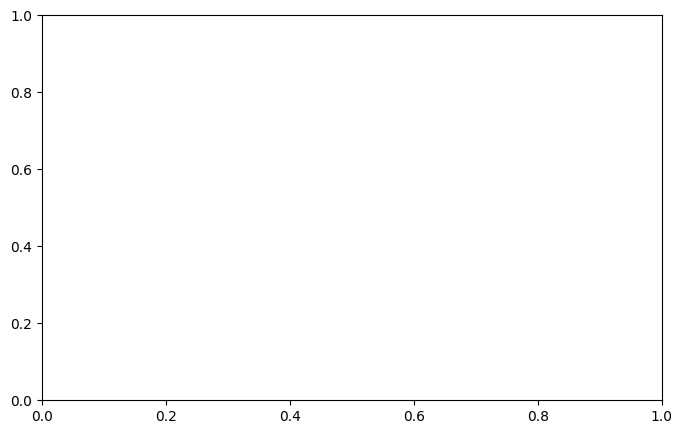

In [7]:
# ========================================
# 5. 定义 Hyperopt 搜索空间
# ========================================
space = {
    "n_estimators": hp.quniform("n_estimators", 800, 1600, 50),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "max_depth": hp.choice("max_depth", [3, 4, 5, 6, 7, 8]),
    "min_child_weight": hp.uniform("min_child_weight", 1, 10),
    "gamma": hp.uniform("gamma", 0.0, 0.5),
    "subsample": hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.8, 2.0),
    "scale_pos_weight": hp.uniform("scale_pos_weight", ratio * 0.5, ratio * 3.0),
}

# ========================================
# 6. 定义目标函数（5-Fold OOF）
# ========================================
def objective(params):
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])

    model = XGBClassifier(
        **params,
        random_state=42,
        eval_metric="aucpr",
        n_jobs=-1,
        use_label_encoder=False
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X_train_proc))

    for train_idx, valid_idx in cv.split(X_train_proc, y_train):
        X_tr, X_val = X_train_proc.iloc[train_idx], X_train_proc.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        oof_preds[valid_idx] = model.predict_proba(X_val)[:, 1]

    # 计算 OOF F1（使用最优 threshold）
    precisions, recalls, thresholds = precision_recall_curve(y_train, oof_preds)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_f1 = np.nanmax(f1_scores)

    return {"loss": -best_f1, "status": STATUS_OK}

# ========================================
# 7. 执行 Hyperopt 搜索
# ========================================
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=80,  # 你可以调到 100+
    trials=trials,
    rstate=np.random.default_rng(42)
)

print("\n🎯 最优参数（Hyperopt）:")
print(best_params)

# ========================================
# 8. 重训练 + OOF 阈值计算
# ========================================
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])

final_model = XGBClassifier(
    **best_params,
    random_state=42,
    eval_metric="aucpr",
    n_jobs=-1,
    use_label_encoder=False
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X_train_proc))
test_preds_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_proc, y_train), 1):
    print(f"===== Fold {fold} =====")
    X_tr, X_val = X_train_proc.iloc[train_idx], X_train_proc.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    final_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

    oof_preds[val_idx] = final_model.predict_proba(X_val)[:, 1]
    test_preds_list.append(final_model.predict_proba(X_test_proc)[:, 1])

test_preds = np.mean(test_preds_list, axis=0)

# ========================================
# 9. 寻找最优阈值（基于 OOF）
# ========================================
precisions, recalls, thresholds = precision_recall_curve(y_train, oof_preds)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.nanmax(f1_scores)

print("\n==========================")
print("✅ OOF Performance")
print(f"Best Threshold = {best_threshold:.3f}")
print(f"OOF Best F1    = {best_f1:.4f}")
print(f"OOF ROC AUC    = {roc_auc_score(y_train, oof_preds):.4f}")
print(f"OOF PR  AUC    = {average_precision_score(y_train, oof_preds):.4f}")
print("==========================\n")

# ========================================
# 10. 测试集评估
# ========================================
test_f1 = f1_score(y_test, (test_preds >= best_threshold).astype(int))
test_auc = roc_auc_score(y_test, test_preds)
test_pr = average_precision_score(y_test, test_preds)

print("测试集表现：")
print(f"F1 = {test_f1:.4f}, ROC AUC = {test_auc:.4f}, PR AUC = {test_pr:.4f}")

# ========================================
# 11. 真实测试集预测与保存
# ========================================
X_real_test_proc = pre.transform(real_test)
X_real_test_proc = X_real_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

final_model.fit(X_train_proc, y_train, verbose=False)
real_pred_proba = final_model.predict_proba(X_real_test_proc)[:, 1]
real_pred_label = (real_pred_proba >= best_threshold).astype(int)

prediction = pd.DataFrame({
    "claim_number": real_test["claim_number"],
    "subrogation": real_pred_label
})
prediction.to_csv("TriGuard_11_XGB.csv", index=False)
print(prediction['subrogation'].value_counts())

# ========================================
# 12. 可视化
# ========================================
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="F1 Curve")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold (OOF)")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
!ls -lh

total 128K
drwx------ 5 root root 4.0K Nov 12 15:32 drive
drwxr-xr-x 1 root root 4.0K Nov  7 14:30 sample_data
-rw-r--r-- 1 root root 118K Nov 12 19:12 TriGuard_11_XGB.csv


In [9]:
from google.colab import files
files.download("TriGuard_11_XGB.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

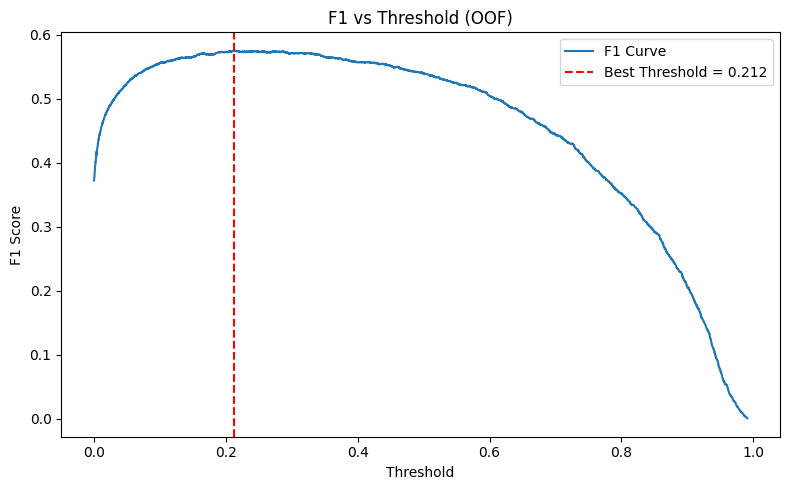

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Curve")  # 去掉最后一个
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold (OOF)")
plt.legend()
plt.tight_layout()
plt.show()